# Crimes Project
#### Enrico Bagattin, Lucrezia Wally Bestetti, Francesco Di Vincenzo, Virginia Massaccesi, Francesca Michielan

The aim of this project is to find out whether crimes in United States are affected by other factors such as unemployment and income. After ascertaining that there exists a relation between crime rate and the other datasets, we forecasted the criminalisation in the USA states.

In [1]:
!pip install folium

# Import libraries
import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
import json
import requests
from sklearn import linear_model
from linear_model import LinearModelCorrelation
from crime_file import CrimeFile
from income_file import generate_simplified as simplify_income_file
from folium_map import FoliumMap


# Constants: CRIME_FILES defines the filename and related years, the datasets directory path of a crime file
CRIME_FILES = [
    pd.Series({'filename': '2011.xls', 'year': 2011, 'nrows': 199}),
    pd.Series({'filename': '2012.xls', 'year': 2012, 'nrows': 200}),
    pd.Series({'filename': '2013.xls', 'year': 2013, 'nrows': 200}),
    pd.Series({'filename': '2014.xls', 'year': 2014, 'nrows': 200}),
    pd.Series({'filename': '2015.xls', 'year': 2015, 'nrows': 199}),
    pd.Series({'filename': '2016.xls', 'year': 2016, 'nrows': 199}),
    pd.Series({'filename': '2017.xls', 'year': 2017, 'nrows': 199})
]
DATASETS_DIRECTORY = 'datasets'
YEARS = [2011, 2012, 2013, 2014, 2015, 2016, 2017]
KEY = '2326dbb5bba84bbc8dd852664c594df7'  # This key is used for OpenCage Geocoder APIs

pd.options.mode.chained_assignment = None  # We've disabled this annoying warning message because there are some cases
# in which we don't care about making overwrites to the original frame.

In [2]:
# ----------------- Functions -----------------


def to_spaced_camel_case(snake_str):
    """
      Format a snake case string into text (ex. to make uniform column names)
      Args:
        snake_str: snake case string
      Return:
        The formatted string
    """
    components = snake_str.split('_')
    title = ''.join(x.title() for x in components)

    return re.sub("([a-z])([A-Z])", "\g<1> \g<2>", title)


def plot_dataframe_correlation(dataframe):
    """
      Plot the r correlation value for all the column combinations
      Args:
        dataframe Dataframe
    """
    plt.clf()  # Clears the plot output figure
    plt.figure(figsize=(15, 15))  # Set the figure size
    correlation_matrix = dataframe.corr()  # Generate a matrix of the correlation coefficient for all the columns
    sns.heatmap(correlation_matrix, annot=True, vmin=-1, vmax=1, square=True)  # Plot an heat map of the previous matrix
    plt.savefig('correlation.png')  # Save the matrix image

    
def predict_crimes_year(df, year):
    """
      Plot the forecasted total crimes rate for the given year
      Args:
        dataframe Dataframe
        int year
    """
    if year > 2017:
        predictions_df = df[df.State == 'United States Total'][['Year', 'Total Crimes', 'Population']].copy()
        prediction_years = list(range(2018, year+1))

        # Crimes rate prediction
        features = predictions_df.Year.unique().reshape(7, 1)  # We use year in order to predict the crimes
        target = predictions_df["Total Crimes"]  # Crimes are our target
        crimes_linear_model = linear_model.LinearRegression()  # Build up the linear model
        crimes_linear_model.fit(features, target)  # Fit the data to the model
        crimes_prediction = crimes_linear_model.predict(X=np.array(prediction_years).reshape(len(prediction_years), 1))
        # Reshape the years in a column (n of rows equal to list length), predict the given years' crimes

        # Population prediction
        target = predictions_df["Population"]
        pop_linear_model = linear_model.LinearRegression()
        pop_linear_model.fit(features, target)
        population_prediction = pop_linear_model.predict(X=np.array(prediction_years).reshape(len(prediction_years), 1))

        # Add predicted values to the dataframe
        for i, year in enumerate(prediction_years):
            predictions_df.loc[len(predictions_df)] = [year, crimes_prediction[i], population_prediction[i]]

        # Plot the lineplot with the forecast values
        plt.clf()
        sns.lineplot(x=predictions_df["Year"], y=predictions_df["Total Crimes"], ci=None).set_title(
            'Prediction Of Total US Crimes Rate', fontsize=20)
        plt.show()

        # Calculate the number of crimes (prediction) and the percentage decrease (from 2017)
        # We've to use the .item() to avoid the index of the row
        prediction_year_row = predictions_df[predictions_df.Year == year]
        prediction_year_crimes = prediction_year_row['Total Crimes'].item() * prediction_year_row.Population.item()
        last_known_year_row = predictions_df[predictions_df.Year == 2017]
        last_known_year_data = last_known_year_row['Total Crimes'].item() * last_known_year_row.Population.item()
        percentage_decrease = (last_known_year_data - prediction_year_crimes)/last_known_year_data
        return {'Predicted number of crimes': int(prediction_year_crimes),
                'Predicted crime rate': prediction_year_row['Total Crimes'].item(),
                'Percentage decrease': "{:.2f}".format(percentage_decrease*100)+'%'}
    else:
        return 'The year is lower than 2017'

# Data loading, cleaning, reshaping and combining
In this section we combined datasets in order to match all the information. With the income dataset we did also a reshaping of information and we add Florida and California data that there were missing in the starting dataset.

In [3]:
# ----------------- Main -----------------

crime = None
# Check if exists the simplified and ready to manipulate crimes' files, otherwise create them
for x in CRIME_FILES:
    file = CrimeFile(x.year, x.nrows, x.filename)  # Creates an instance of a CrimeFile object
    file_path = file.generate_simplified()  # Drop unnecessary data
    xls = pd.ExcelFile(file_path)
    new_frame = pd.read_excel(xls, header=0)  # Open the simplified file
    # Appending the crimes data-frames
    if crime is None:
        crime = new_frame
    else:
        crime = crime.append(new_frame, ignore_index=True, sort=False)

# Add sum of crimes column
sum_of_crimes = crime.iloc[:, 3:14].sum(axis=1)
crime['Total Crimes'] = sum_of_crimes
# Normalizing all columns (by dividing all the crimes by the state population)
crime.iloc[:, 3:15] = crime.iloc[:, 3:15].div(crime.Population, axis=0)

final_dataset = crime
crime

Area  Year  Population  Violent crime  \
0    United States Total  2011   311591917       0.003863   
1              Northeast  2011    55521598       0.003521   
2            New England  2011    14492360       0.003143   
3            Connecticut  2011     3580709       0.002728   
4                  Maine  2011     1328188       0.001232   
5          Massachusetts  2011     6587536       0.004284   
6          New Hampshire  2011     1318194       0.001880   
7           Rhode Island  2011     1051302       0.002475   
8                Vermont  2011      626431       0.001352   
9        Middle Atlantic  2011    41029238       0.003654   
10            New Jersey  2011     8821155       0.003084   
11              New York  2011    19465197       0.003981   
12          Pennsylvania  2011    12742886       0.003550   
13               Midwest  2011    67158835       0.003499   
14    East North Central  2011    46519084       0.003652   
15              Illinois  2011    12869257       0.004293   
16               Indiana  2011     6516922       0.003318   
17              Michigan  2011     9876187       0.004453   
18                  Ohio  2011    11544951       0.003074   
19             Wisconsin  2011     5711767       0.002369   
20    West North Central  2011    20639751       0.003157   
21                  Iowa  2011     3062309       0.002556   
22                Kansas  2011     2871238       0.003539   
23             Minnesota  2011     5344861       0.002212   
24              Missouri  2011     6010688       0.004474   
25              Nebraska  2011     1842641       0.002532   
26          North Dakota  2011      683932       0.002470   
27          South Dakota  2011      824082       0.002541   
28                 South  2011   116046736       0.004288   
29        South Atlantic  2011    60513771       0.004271   
..                   ...   ...         ...            ...   
432       South Carolina  2017     5024369       0.005062   
433             Virginia  2017     8470020       0.002082   
434        West Virginia  2017     1815857       0.003507   
435   East South Central  2017    19029020       0.004619   
436              Alabama  2017     4874747       0.005242   
437             Kentucky  2017     4454189       0.002258   
438          Mississippi  2017     2984100       0.002857   
439            Tennessee  2017     6715984       0.006515   
440   West South Central  2017    39924072       0.004632   
441             Arkansas  2017     3004279       0.005549   
442            Louisiana  2017     4684333       0.005570   
443             Oklahoma  2017     3930864       0.004562   
444                Texas  2017    28304596       0.004389   
445                 West  2017    77410622       0.004231   
446             Mountain  2017    24158117       0.004385   
447              Arizona  2017     7016270       0.005080   
448             Colorado  2017     5607154       0.003681   
449                Idaho  2017     1716943       0.002264   
450              Montana  2017     1050493       0.003771   
451               Nevada  2017     2998039       0.005559   
452           New Mexico  2017     2088070       0.007835   
453                 Utah  2017     3101833       0.002389   
454              Wyoming  2017      579315       0.002375   
455              Pacific  2017    53252505       0.004161   
456               Alaska  2017      739795       0.008290   
457           California  2017    39536653       0.004493   
458               Hawaii  2017     1427538       0.002506   
459               Oregon  2017     4142776       0.002818   
460           Washington  2017     7405743       0.003045   
461          Puerto Rico  2017     3337177       0.002326   

     Murder and nonnegligent manslaughter  Forcible rape   Robbery  \
0                                0.000047       0.000268  0.001137   
1                                0.000039       0.000192  0.001240   
2                          

In [4]:
# Unemployment dataset
# Importing the dataset and the two missing states data
path = os.path.join(DATASETS_DIRECTORY, 'unemployment-by-county-us', 'output.csv')
unemployment_frame = pd.read_csv(path)
other_countries = []
other_countries += [(pd.read_csv(os.path.join(DATASETS_DIRECTORY, 'unemployment-by-county-us',
                                              'Georgia.csv')), 'Georgia')]
other_countries += [(pd.read_csv(os.path.join(DATASETS_DIRECTORY, 'unemployment-by-county-us',
                                              'Florida.csv')), 'Florida')]
for country, state in other_countries:
    country['State'] = state
    simplified = country[['Year', 'State', 'unemployment rate']]
    simplified.rename(columns={"unemployment rate": "Rate"}, inplace=True)
    unemployment_frame = unemployment_frame.append(simplified, sort=True)  # Append the two missing states
# Group all the data by Year and State (taking the mean of all the months data)
unemployment_frame = unemployment_frame.groupby(['Year', 'State']).mean()  
# Merge the unemployment dataframe with the previous one
final_dataset = final_dataset.merge(unemployment_frame, how='left', left_on=['Area', 'Year'],
                                    right_on=['State', 'Year'])

final_dataset

Area  Year  Population  Violent crime  \
0    United States Total  2011   311591917       0.003863   
1              Northeast  2011    55521598       0.003521   
2            New England  2011    14492360       0.003143   
3            Connecticut  2011     3580709       0.002728   
4                  Maine  2011     1328188       0.001232   
5          Massachusetts  2011     6587536       0.004284   
6          New Hampshire  2011     1318194       0.001880   
7           Rhode Island  2011     1051302       0.002475   
8                Vermont  2011      626431       0.001352   
9        Middle Atlantic  2011    41029238       0.003654   
10            New Jersey  2011     8821155       0.003084   
11              New York  2011    19465197       0.003981   
12          Pennsylvania  2011    12742886       0.003550   
13               Midwest  2011    67158835       0.003499   
14    East North Central  2011    46519084       0.003652   
15              Illinois  2011    12869257       0.004293   
16               Indiana  2011     6516922       0.003318   
17              Michigan  2011     9876187       0.004453   
18                  Ohio  2011    11544951       0.003074   
19             Wisconsin  2011     5711767       0.002369   
20    West North Central  2011    20639751       0.003157   
21                  Iowa  2011     3062309       0.002556   
22                Kansas  2011     2871238       0.003539   
23             Minnesota  2011     5344861       0.002212   
24              Missouri  2011     6010688       0.004474   
25              Nebraska  2011     1842641       0.002532   
26          North Dakota  2011      683932       0.002470   
27          South Dakota  2011      824082       0.002541   
28                 South  2011   116046736       0.004288   
29        South Atlantic  2011    60513771       0.004271   
..                   ...   ...         ...            ...   
432       South Carolina  2017     5024369       0.005062   
433             Virginia  2017     8470020       0.002082   
434        West Virginia  2017     1815857       0.003507   
435   East South Central  2017    19029020       0.004619   
436              Alabama  2017     4874747       0.005242   
437             Kentucky  2017     4454189       0.002258   
438          Mississippi  2017     2984100       0.002857   
439            Tennessee  2017     6715984       0.006515   
440   West South Central  2017    39924072       0.004632   
441             Arkansas  2017     3004279       0.005549   
442            Louisiana  2017     4684333       0.005570   
443             Oklahoma  2017     3930864       0.004562   
444                Texas  2017    28304596       0.004389   
445                 West  2017    77410622       0.004231   
446             Mountain  2017    24158117       0.004385   
447              Arizona  2017     7016270       0.005080   
448             Colorado  2017     5607154       0.003681   
449                Idaho  2017     1716943       0.002264   
450              Montana  2017     1050493       0.003771   
451               Nevada  2017     2998039       0.005559   
452           New Mexico  2017     2088070       0.007835   
453                 Utah  2017     3101833       0.002389   
454              Wyoming  2017      579315       0.002375   
455              Pacific  2017    53252505       0.004161   
456               Alaska  2017      739795       0.008290   
457           California  2017    39536653       0.004493   
458               Hawaii  2017     1427538       0.002506   
459               Oregon  2017     4142776       0.002818   
460           Washington  2017     7405743       0.003045   
461          Puerto Rico  2017     3337177       0.002326   

     Murder and nonnegligent manslaughter  Forcible rape   Robbery  \
0                                0.000047       0.000268  0.001137   
1                                0.000039       0.000192  0.001240   
2                          

In [5]:
# Income dataset
final_path = simplify_income_file()  # Generate the reshaped income file
income_frame = pd.read_csv(final_path, index_col=[0, 1], usecols=['Area', 'Year', 'Income'])

In [6]:
# Merging income dataset with the final one
final_dataset = final_dataset.merge(income_frame, how='left', on=['Area', 'Year'])

# Exporting final data-frame
final_dataset.columns = [to_spaced_camel_case(x) for x in final_dataset.columns]
final_dataset.rename(columns={"Area": "State", "Rate": "Rate Of Unemployment"}, inplace=True)

path = os.path.join(DATASETS_DIRECTORY, 'merged.xls')
final_dataset.to_excel(path, sheet_name='All datasets', index=True)

path = os.path.join(DATASETS_DIRECTORY, 'merged.csv')
final_dataset.to_csv(path, index=True)

final_dataset

State  Year  Population  Violent Crime  \
0    United States Total  2011   311591917       0.003863   
1              Northeast  2011    55521598       0.003521   
2            New England  2011    14492360       0.003143   
3            Connecticut  2011     3580709       0.002728   
4                  Maine  2011     1328188       0.001232   
5          Massachusetts  2011     6587536       0.004284   
6          New Hampshire  2011     1318194       0.001880   
7           Rhode Island  2011     1051302       0.002475   
8                Vermont  2011      626431       0.001352   
9        Middle Atlantic  2011    41029238       0.003654   
10            New Jersey  2011     8821155       0.003084   
11              New York  2011    19465197       0.003981   
12          Pennsylvania  2011    12742886       0.003550   
13               Midwest  2011    67158835       0.003499   
14    East North Central  2011    46519084       0.003652   
15              Illinois  2011    12869257       0.004293   
16               Indiana  2011     6516922       0.003318   
17              Michigan  2011     9876187       0.004453   
18                  Ohio  2011    11544951       0.003074   
19             Wisconsin  2011     5711767       0.002369   
20    West North Central  2011    20639751       0.003157   
21                  Iowa  2011     3062309       0.002556   
22                Kansas  2011     2871238       0.003539   
23             Minnesota  2011     5344861       0.002212   
24              Missouri  2011     6010688       0.004474   
25              Nebraska  2011     1842641       0.002532   
26          North Dakota  2011      683932       0.002470   
27          South Dakota  2011      824082       0.002541   
28                 South  2011   116046736       0.004288   
29        South Atlantic  2011    60513771       0.004271   
..                   ...   ...         ...            ...   
432       South Carolina  2017     5024369       0.005062   
433             Virginia  2017     8470020       0.002082   
434        West Virginia  2017     1815857       0.003507   
435   East South Central  2017    19029020       0.004619   
436              Alabama  2017     4874747       0.005242   
437             Kentucky  2017     4454189       0.002258   
438          Mississippi  2017     2984100       0.002857   
439            Tennessee  2017     6715984       0.006515   
440   West South Central  2017    39924072       0.004632   
441             Arkansas  2017     3004279       0.005549   
442            Louisiana  2017     4684333       0.005570   
443             Oklahoma  2017     3930864       0.004562   
444                Texas  2017    28304596       0.004389   
445                 West  2017    77410622       0.004231   
446             Mountain  2017    24158117       0.004385   
447              Arizona  2017     7016270       0.005080   
448             Colorado  2017     5607154       0.003681   
449                Idaho  2017     1716943       0.002264   
450              Montana  2017     1050493       0.003771   
451               Nevada  2017     2998039       0.005559   
452           New Mexico  2017     2088070       0.007835   
453                 Utah  2017     3101833       0.002389   
454              Wyoming  2017      579315       0.002375   
455              Pacific  2017    53252505       0.004161   
456               Alaska  2017      739795       0.008290   
457           California  2017    39536653       0.004493   
458               Hawaii  2017     1427538       0.002506   
459               Oregon  2017     4142776       0.002818   
460           Washington  2017     7405743       0.003045   
461          Puerto Rico  2017     3337177       0.002326   

     Murder And Nonnegligent Manslaughter  Forcible Rape   Robbery  \
0                                0.000047       0.000268  0.001137   
1                                0.000039       0.000192  0.001240   
2                         

# Data visualization and data analysis

In this section of the code we plotted the correlation graphic maps to find out if there exists a correlation between crimes and the two variables rate of unemployment and income.
Beside that, we made plotted specific graphs to search for a linear correlation, first between rate of unemployment and crimes and then between income and crimes. In both cases we looked for the correlation coefficient to verify whether there exist a relationship.


In [7]:
# Folium map

map_obj = FoliumMap(final_dataset, [48, -102], 'us-states.json')
columns = ['Rate Of Unemployment', 'Total Crimes', 'Income']
year = None

def print_map():
    with(out):
        global columns
        global year
        clear_output()
        map = map_obj.generate_map(columns, year, with_markers=True)
        display(map)

# Interacting with map (buttons below are used like checkbox, the initial value is true)

from ipywidgets import *
from IPython.display import display, clear_output
      
def click(b):
    with(out):
        global columns
        if b.description == 'All':
            columns == ['Rate Of Unemployment', 'Total Crimes', 'Income']
        else:
            if b.description == 'Unemployment':
                col = 'Rate Of Unemployment'
            elif b.description == 'Crimes':
                col = 'Total Crimes'
            else:
                col = 'Income'
            if col in columns:
                columns.remove(col)
            else:
                columns += [col]
        
        if not columns:
            clear_output()
        else:
            print_map()

out = Output()

button_0=Button(description='All')
button_1=Button(description='Unemployment', style={'position': 'right'})
button_2=Button(description='Crimes')
button_3=Button(description='Income')
button_0.on_click(click)
button_1.on_click(click)
button_2.on_click(click)
button_3.on_click(click)

slider = SelectionSlider(
    options=['All'] + YEARS,
    value='All',
    description='Year:'
)

def slider_f(value):
    global year
    if slider.value == 'All':
        value = None
    else:
        value = slider.value
    if year != value:
        year = value
        print_map()
    
slider.observe(slider_f)

display(HBox([button_0, button_1, button_2, button_3, slider]))
display(out)
print_map()

Output()

<Figure size 432x288 with 0 Axes>

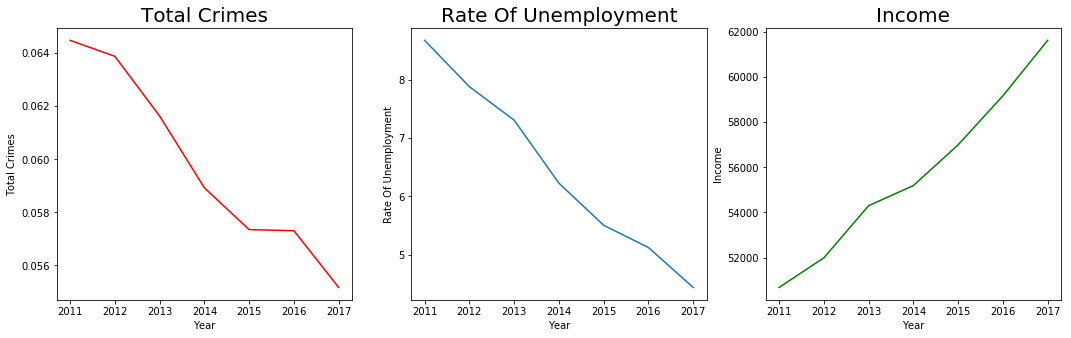

In [8]:
# Data visualization
plt.clf()

fig = plt.figure(figsize=(18,5))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

sns.lineplot(x=final_dataset["Year"], y=final_dataset["Total Crimes"], 
             color="r", ci=None, ax=ax1).set_title('Total Crimes', fontsize=20)
sns.lineplot(x=final_dataset["Year"], y=final_dataset["Rate Of Unemployment"], 
             ci=None, ax=ax2).set_title('Rate Of Unemployment', fontsize=20)
sns.lineplot(x=final_dataset["Year"], y=final_dataset["Income"], color="g", 
             ci=None, ax=ax3).set_title('Income', fontsize=20)
plt.show()

<Figure size 432x288 with 0 Axes>

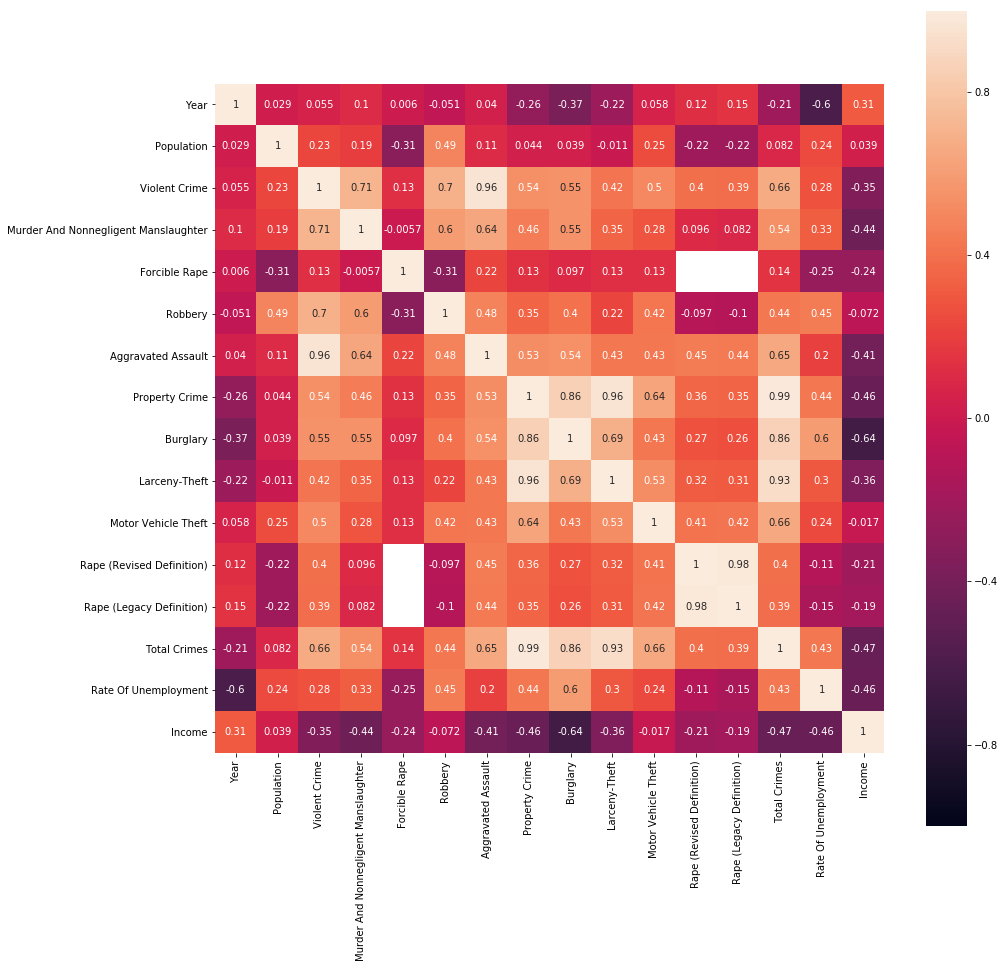

In [9]:
# Analysis
# Let's see the correlation (r) all over the columns
plot_dataframe_correlation(final_dataset[pd.notna(final_dataset['Rate Of Unemployment'])
                                         & pd.notna(final_dataset.Income)])

As we can see from the values of the heatmap, the correlation differs for each kind of crime. In particular we can observe that the burglary has the highest rate of correlation for both rate of unemployment and income, on the other hand the correlation with motor vehicle theft is irrelavant in both cases. We use Total Crimes as the reference variable to study the relationships with the other ones.

## Rate of unemployment analysis

C:\Users\enric\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


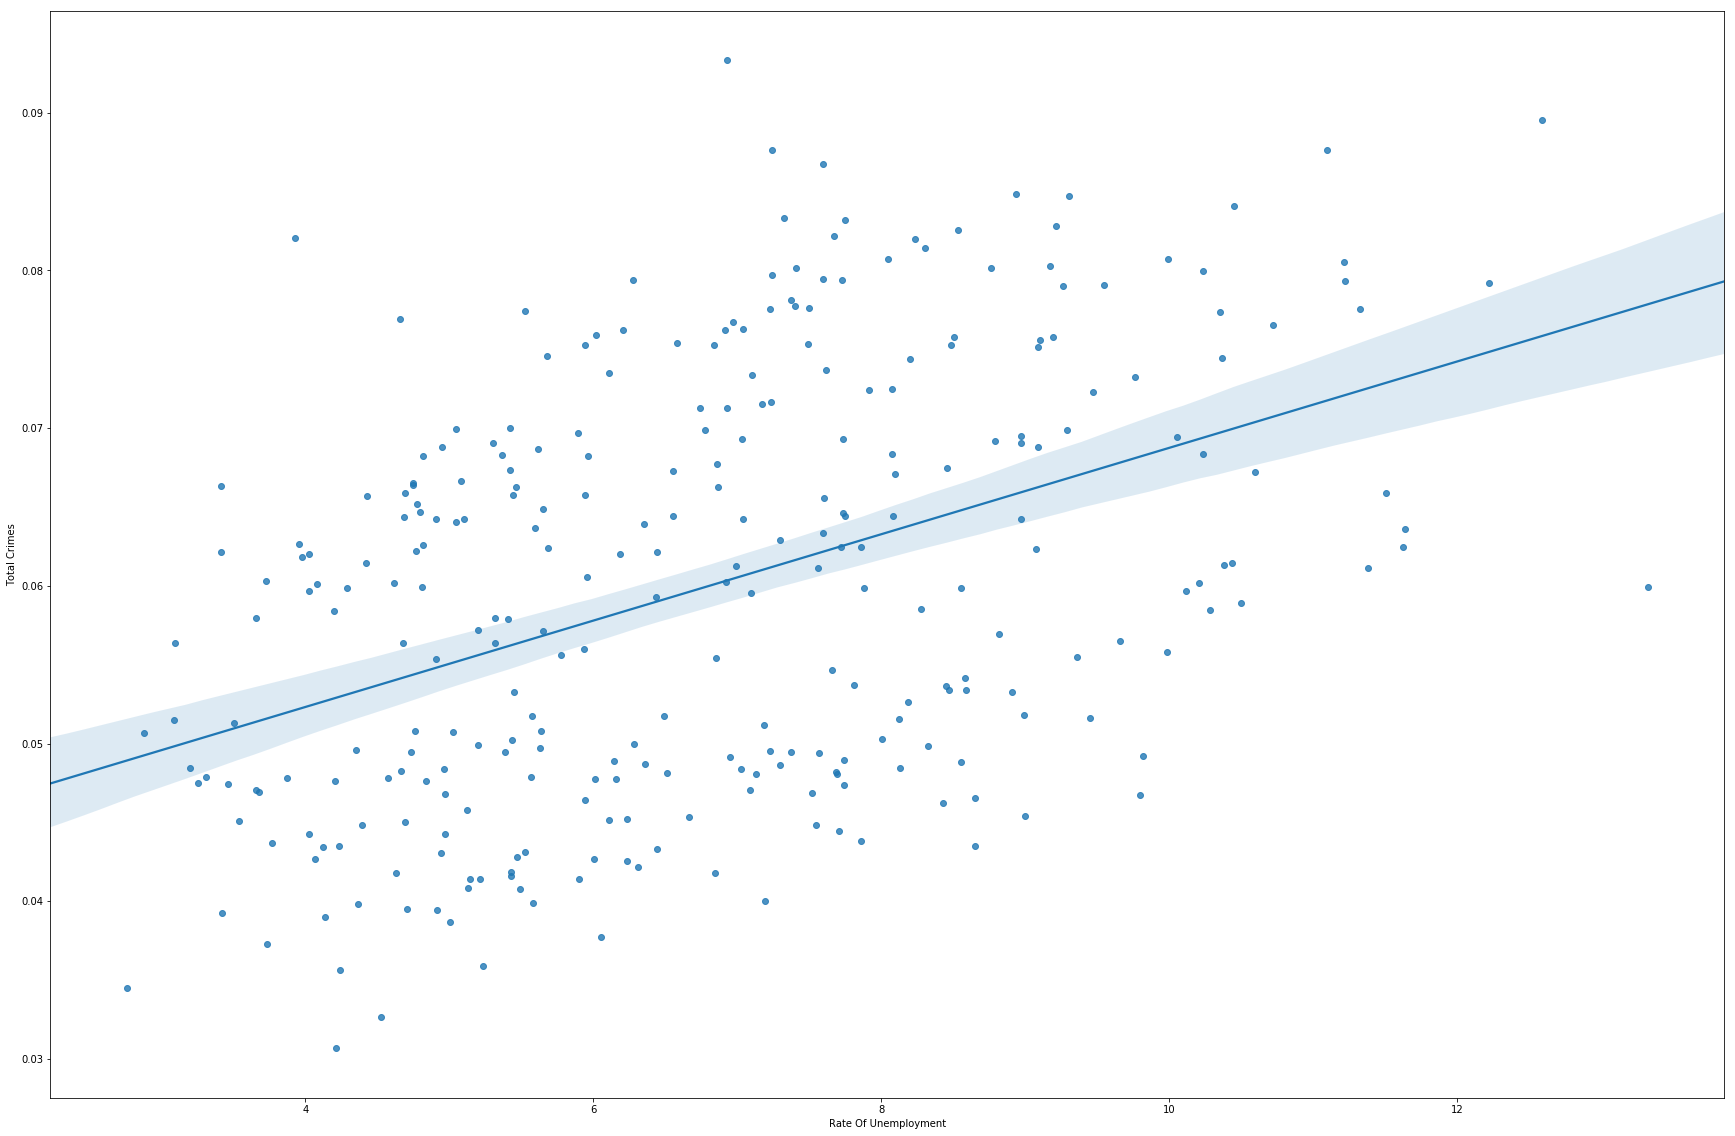

In [10]:
analysis_frame = final_dataset[pd.notna(final_dataset['Rate Of Unemployment'])].copy()
# Linear model between the two
# Plot linear models
unemployment_crimes = LinearModelCorrelation('Rate Of Unemployment', 'Total Crimes', analysis_frame)
unemployment_crimes.scatter_plot()

<Figure size 432x288 with 0 Axes>

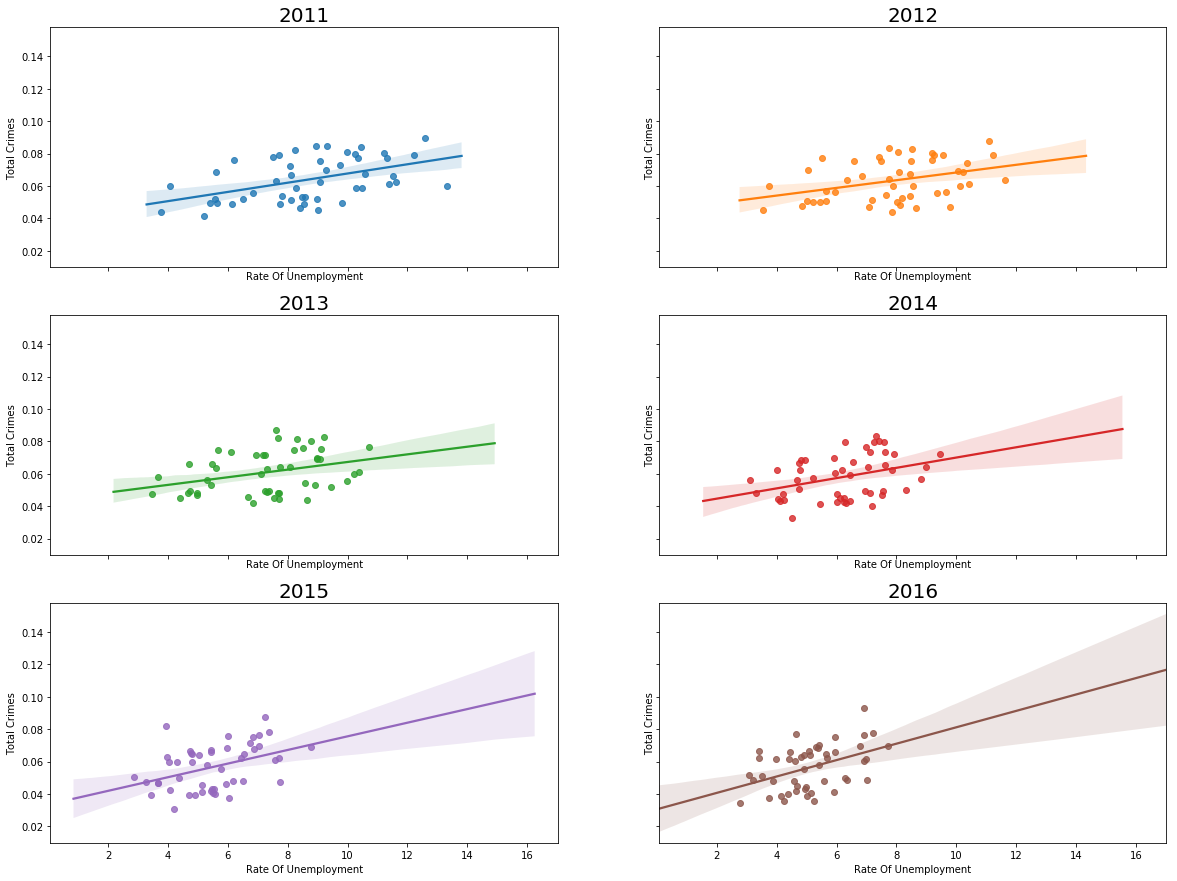

In [11]:
years = [2011, 2012, 2013, 2014, 2015, 2016]
unemployment_crimes.scatter_plot(years)

In [12]:
for year in years:
    print(year, unemployment_crimes.correlation(year))

2011 {'r': 0.4687655369143944, 'se': 0.0007824423630323872, 'r2': 0.21974112859864042, 'slope': 0.0028466731346430125}
2012 {'r': 0.37213460246733576, 'se': 0.0008640207022845379, 'r2': 0.138484162353522, 'slope': 0.0023748790633410346}
2013 {'r': 0.3336678584622419, 'se': 0.0009713502695587717, 'r2': 0.11133423977077869, 'slope': 0.002357056235959546}
2014 {'r': 0.36215019459355746, 'se': 0.0011906415136103707, 'r2': 0.13115276344415153, 'slope': 0.003171370343435282}
2015 {'r': 0.4125745386851733, 'se': 0.0013553269387366516, 'r2': 0.17021774997128356, 'slope': 0.004208364534402636}
2016 {'r': 0.4445045862954476, 'se': 0.0014879190680124504, 'r2': 0.197584327237687, 'slope': 0.005061797689902015}


The regression analysis is used to explain in numeric terms the linear relationship between two numerical variables using a linear equation. The regression equation is the equation of a line that describes how, on average, the response variable is related to the explanatory variable. The equation of the regression line is y = a + bx where a is the intercept, b is the slope, x is the value of the explanatory variable and y is an approximation value (called predicted value) of the response variable.

Generally speaking, if the correlation coefficient (r) is equal to 1 we have a perfect positive relationship and if it is -1 there is a perfect negative relationship, so if r=0 there is no linear relationship.
Coefficient of determination R2 is the fraction (percentage) of variation in the response variable Y (Crime) that is explainable by the predictor variable X (rate of unemployment). The range of Rs is between 0 and 1: when R2=0 there is no linear association and if R2=1 there is perfect linear relationship.

| YEAR   |      CORRELATION COEFFICIENT      |         ANALYSIS         |
|:------:|:---------------------------------:|:------------------------:|
|  2011  |        0.4687655369143945         | Moderate uphill relation |
|  2012  |        0.3721346024673356         | Weak uphill relation     |
|  2013  |        0.3336678584622419         | Weak uphill relation     |
|  2014  |        0.3621501945935572         | Weak uphill relation     |
|  2015  |        0.4125745386851734         | Moderate uphill relation |
|  2016  |        0.4445045862954475         | Moderate uphill relation |


By looking at the data we can say that 2011 and 2016 are the two years with the higher linear correlation.



## Income analysis

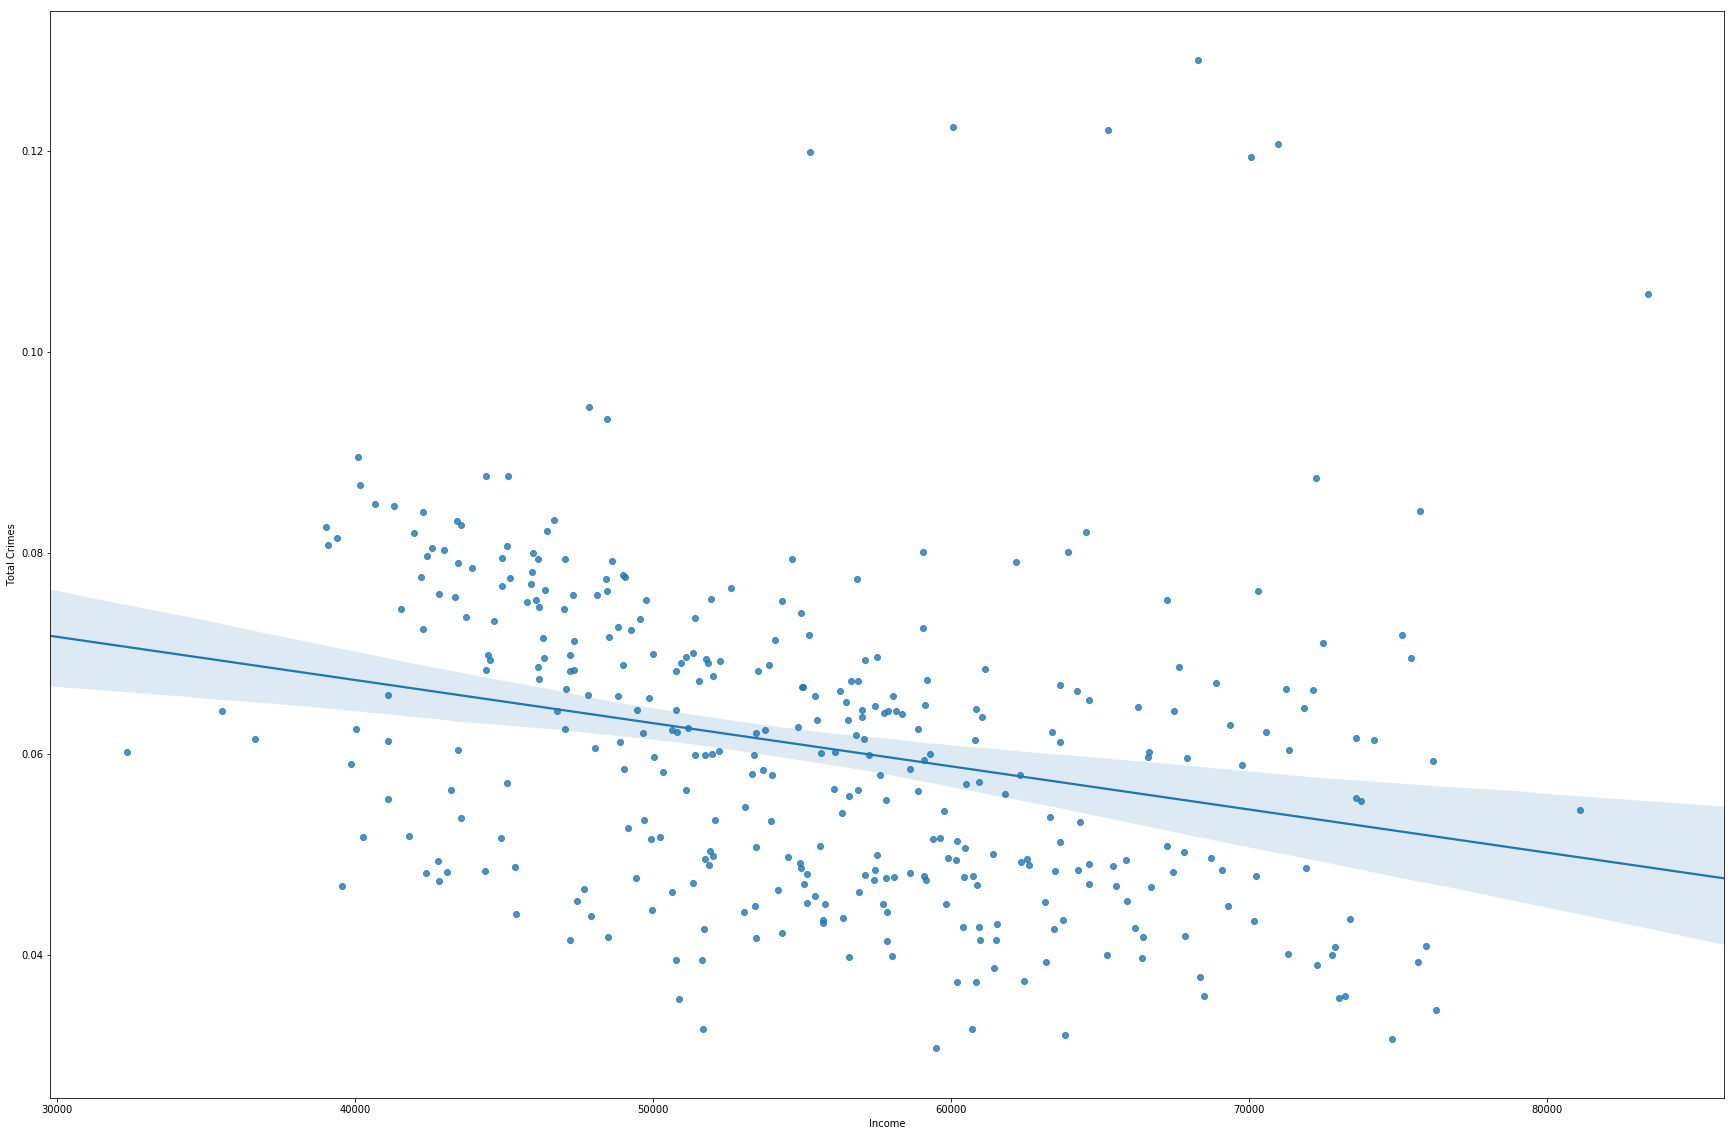

In [13]:
analysis_frame = final_dataset[(final_dataset.State != 'United States Total') & (pd.notna(final_dataset.Income))].copy()

# Linear model between the two
# Plot linear models
income_crimes = LinearModelCorrelation('Income', 'Total Crimes', analysis_frame)
income_crimes.scatter_plot()


<Figure size 432x288 with 0 Axes>

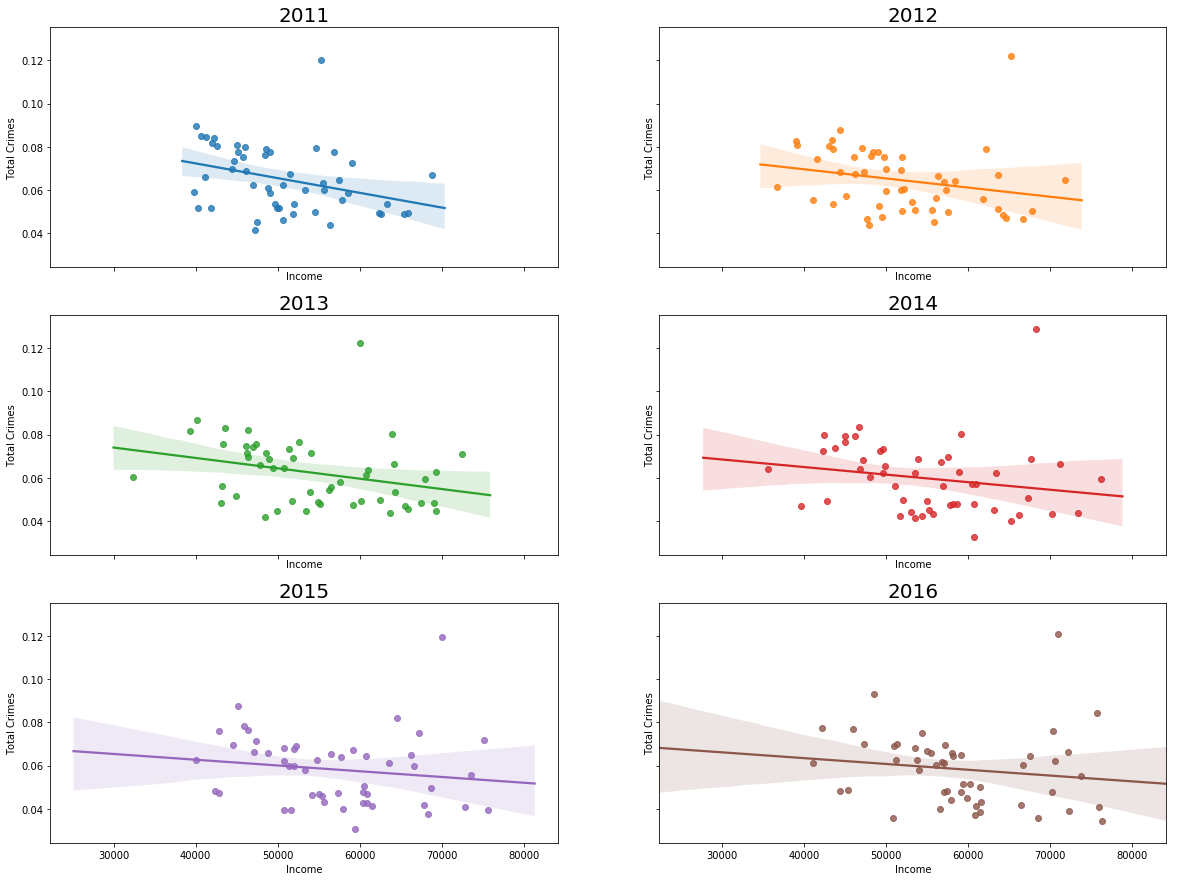

In [14]:
years = [2011, 2012, 2013, 2014, 2015, 2016]
income_crimes.scatter_plot(years)

In [15]:
for year in years:
    print(year, income_crimes.correlation(year))

2011 {'r': -0.3325250987895297, 'se': 2.757225615078279e-07, 'r2': 0.11057294132498648, 'slope': -6.805179841247668e-07}
2012 {'r': -0.2393294783735561, 'se': 2.4528439528448575e-07, 'r2': 0.05727859921855845, 'slope': -4.232261278004936e-07}
2013 {'r': -0.29298547618715926, 'se': 2.2366639206917565e-07, 'r2': 0.08584048925661646, 'slope': -4.797708676175424e-07}
2014 {'r': -0.1964082403557681, 'se': 2.4947400218407226e-07, 'r2': 0.03857619687964917, 'slope': -3.4980467061057245e-07}
2015 {'r': -0.15193498871563493, 'se': 2.474059616638816e-07, 'r2': 0.023084240796020113, 'slope': -2.6621801486533257e-07}
2016 {'r': -0.14779599371481209, 'se': 2.56720970951981e-07, 'r2': 0.021843655758148773, 'slope': -2.6854551926727077e-07}


| YEAR   |      CORRELATION COEFFICIENT      |         ANALYSIS         |
|:------:|:---------------------------------:|:------------------------:|
|  2011  |             -0.3325               | Moderate uphill relation |
|  2012  |             -0.2393               | Weak uphill relation     |
|  2013  |             -0.2929               | Weak uphill relation     |
|  2014  |             -0.1964               | Weak uphill relation     |
|  2015  |             -0.1519               | Moderate uphill relation |
|  2016  |             -0.1478               | Moderate uphill relation |


By looking at the data we can say that in 2015 and 2016 there is less linear correlation between income and crimes.

In fact, by observing the graphs we see that as years go by, the values are more scattered, which means that there is an increasing in the relationship between our variables. 

This consideration is also observable thanks to R2 coefficient that represents the percentage correlation between income and crimes; as a matter of fact in 2011 there is 11% of probability that total crimes is correlate to income rather than in 2016 were there is 2% of probability that they are correlated.




# Prediction of total US crimes rate
At the end of our project, we add the probable forecast for the future years. 

Users can type a year, above 2017, and the program will return the probable plot until the chosen year and it will also show the predicted number of crimes regarding the forcasting population.

Obviously the predicition is not reliable because we assume that the developing of crimes during the year is linear and not affected by any factors.


<Figure size 432x288 with 0 Axes>

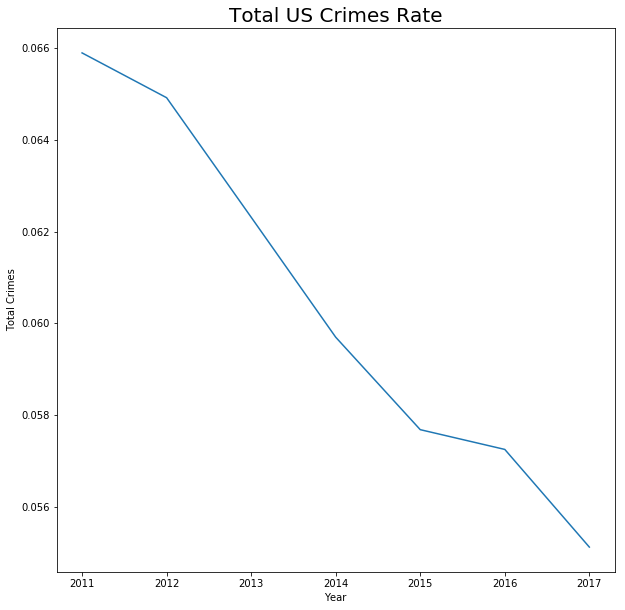

In [16]:
# Predictions
df = final_dataset
plt.clf()
fig = plt.figure(figsize=(10,10))
sns.lineplot(x=df["Year"], y=df[df.State == 'United States Total']["Total Crimes"],
             ci=None).set_title('Total US Crimes Rate', fontsize=20)
plt.show()

Insert the year to forecast total crimes rate (bigger than 2017):2030


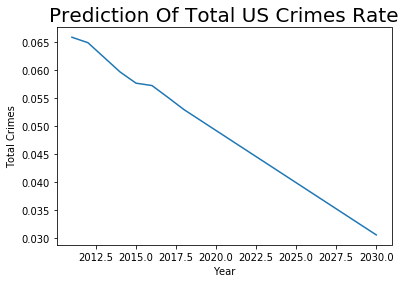

{'Predicted number of crimes': 10882222, 'Predicted crime rate': 0.030529424089794865, 'Percentage decrease': '39.39%'}


In [17]:
input_year = 0
while int(input_year) <= 2017:
    input_year = input('Insert the year to forecast total crimes rate (bigger than 2017):')
    print(predict_crimes_year(final_dataset, int(input_year)))